In [9]:
from scipy.stats import norm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
FILE_PATH = "/Users/gregoireszymanski/Documents/data/vol/oxfordmanrealizedvolatilityindices.csv"
data = pd.read_csv(FILE_PATH, memory_map=True)

In [11]:
symbols = data["Symbol"].unique()

In [12]:
symbol = ".DJI"
filtered = data[data["Symbol"] == symbol][["Date", "rv10"]]

# Naive GMM

In [13]:
##### Preliminary functions

def Phi_Hl(l: int, H: float) -> float:
    """
    Compute the value of $\\Phi^H_\\ell$ using a finite difference formula.

    This function evaluates a discrete approximation based on powers of absolute values,
    commonly used in fractional Brownian motion and related models.

    :param l: Index $\\ell$ in the formula (integer).
    :param H: Hurst exponent $H$, controlling the memory effect (float).
    :return: Computed value of $\\Phi^H_\\ell$.
    """
    numerator = (np.abs(l + 2) ** (2 * H + 2) - 4 * np.abs(l + 1) ** (2 * H + 2) +
                 6 * np.abs(l) ** (2 * H + 2) - 4 * np.abs(l - 1) ** (2 * H + 2) +
                 np.abs(l - 2) ** (2 * H + 2))
    denominator = 2 * (2 * H + 1) * (2 * H + 2)
    return numerator / denominator

def dPhi_Hl_dH(l: int, H: float) -> float:
    """
    Compute the derivative of $\\Phi^H_\\ell$ with respect to $H$.

    Uses the chain rule to differentiate power terms in the finite difference formula.

    :param l: Index $\\ell$ in the formula (integer).
    :param H: Hurst exponent $H$ (float).
    :return: The computed derivative $\\frac{d}{dH} \\Phi^H_\\ell$.
    """
    def power_term_derivative(x, H):
        if x == 0:
            return 0
        return (2 * x ** (2 * H + 2) * np.log(np.abs(x)))
    
    numerator = (np.abs(l + 2) ** (2 * H + 2) - 4 * np.abs(l + 1) ** (2 * H + 2) +
                 6 * np.abs(l) ** (2 * H + 2) - 4 * np.abs(l - 1) ** (2 * H + 2) +
                 np.abs(l - 2) ** (2 * H + 2))

    numerator_derivative = (
        power_term_derivative(np.abs(l + 2), H) - 4 * power_term_derivative(np.abs(l + 1), H) +
        6 * power_term_derivative(np.abs(l), H) - 4 * power_term_derivative(np.abs(l - 1), H) +
        power_term_derivative(np.abs(l - 2), H)
    )
    
    denominator = 2 * (2 * H + 1) * (2 * H + 2)
    denominator_derivative = 4 * (4 * H + 3)
    
    return (numerator_derivative * denominator - denominator_derivative * numerator) / (denominator * denominator)

##### GMM estimator

def F_estimation_GMM(W: np.ndarray, V: np.ndarray, Psi_func, H: list, normalisation: float = 1) -> float:
    """
    Compute the GMM objective function $F(H, R)$ for given parameters.
    
    This function minimizes:
    
    $$ F(H, R) = (V - P)^T W (V - P) $$
    
    where $P$ is computed based on $H$.

    :param W: Weight matrix (numpy array).
    :param V: Observation vector (numpy array).
    :param Psi_func: Function $\\Psi(H)$ providing model predictions.
    :param H: Scalar Hurst exponent wrapped in a list.
    :param normalisation: Normalization factor for the function value.
    :return: Evaluated objective function value.
    """

    H = H[0]
    V = np.atleast_2d(V).reshape(-1, 1)
    Psi = np.atleast_2d(Psi_func(H)).reshape(-1, 1)
        
    term0 = V.T @ W @ V
    term1 = (Psi.T @ W @ V) + (V.T @ W @ Psi)
    term2 = Psi.T @ W @ Psi
    
    term0 = term0[0, 0]
    term1 = term1[0, 0]
    term2 = term2[0, 0]
    
    R = term1 / term2 / 2
    
    return normalisation * (term0 - R * term1 + term2 * R * R)

def F_GMM_get_R(W: np.ndarray, V: np.ndarray, Psi_func, H: float) -> float:
    V = np.atleast_2d(V).reshape(-1, 1)
    Psi = np.atleast_2d(Psi_func(H)).reshape(-1, 1)
        
    term0 = V.T @ W @ V
    term1 = (Psi.T @ W @ V) + (V.T @ W @ Psi)
    term2 = Psi.T @ W @ Psi
    
    term0 = term0[0, 0]
    term1 = term1[0, 0]
    term2 = term2[0, 0]
    
    R = term1 / term2 / 2
    
    return R

def estimation_GMM(W: np.ndarray, V: np.ndarray, Psi_func, H_min: float = 0.001, H_max: float = 0.499, mesh: float = 0.001, debug: bool = False):
    """
    Perform Generalized Method of Moments (GMM) estimation for the Hurst exponent.
    
    This method finds $H$ that minimizes the GMM objective function over a predefined grid.
    
    :param W: Weight matrix (numpy array).
    :param V: Observation vector (numpy array).
    :param Psi_func: Function returning model predictions $\\Psi(H)$.
    :param H_min: Minimum value for H search grid.
    :param H_max: Maximum value for H search grid.
    :param mesh: Step size for grid search.
    :param debug: If True, return intermediate results.
    :return: Estimated Hurst exponent.
    """
    H_values = np.arange(H_min, H_max, mesh)
    F_values = [F_estimation_GMM(W, V, Psi_func, [H]) for H in H_values]
    min_index = np.argmin(F_values)
    
    if debug:
        R_values = [F_GMM_get_R(W, V, Psi_func, H) for H in H_values]
        return H_values, F_values, min_index, R_values

    return H_values[min_index], F_GMM_get_R(W, V, Psi_func, H_values[min_index])



In [15]:
N_lags = 30

time_series_volatility = filtered['rv10'].to_numpy()
vol_increments = time_series_volatility[1:] - time_series_volatility[:-1]
variance = np.mean(vol_increments**2)
autocorrels = [
    np.mean(vol_increments[k:] * vol_increments[:-k]) 
    for k in range(1, N_lags)
]

autocorrels = np.array(
    [variance] + autocorrels
)


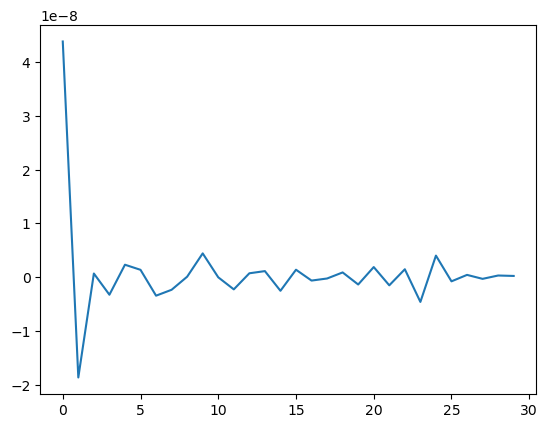

In [16]:
plt.plot(autocorrels)

In [23]:
np.sum(autocorrels[2:] / autocorrels[0])

-0.054984085226392365

In [17]:
def create_Psi_function(window: int, N_lags: int):
    def Psi(H):
        p = []

        factor = window**(2 * H)
        
        # Compute the first two terms outside the loop
        for i in range(N_lags):
            p.append(factor * Phi_Hl(i, H))

        return np.array(p)
    return Psi



In [20]:
Psi = create_Psi_function(1.0/252.0, N_lags)

estimation_GMM(np.identity(N_lags),
                autocorrels,
                Psi,
                0.0001,
                0.4999,
                0.0001)

(0.0001, 0.00016203339080971796)

In [ ]:
autocorrel_1 / variance

-0.46052726801282834

In [32]:
Phi_Hl(1, -0.42) / Phi_Hl(0, -0.42)

-0.46397388819673596

In [1]:
df

NameError: name 'df' is not defined